# Tree Parity Machine Key Exchange and Attack Simulation


## **Introduction**

In the evolving landscape of cybersecurity, traditional cryptographic methods continue to face increasing scrutiny, particularly in the context of emerging quantum threats and side-channel vulnerabilities. As a response, alternative approaches based on neural networks and synchronization phenomena have gained significant attention. One such method is the **Tree Parity Machine (TPM)** key exchange protocol, a symmetric key exchange model leveraging the mutual learning capability of neural networks.

This notebook presents an experimental and pedagogical exploration of the TPM synchronization protocol as a means for **secure key exchange** between two parties traditionally referred to as **Alice** and **Bob**. Using a model inspired by research in neural cryptography, Alice and Bob are able to synchronize their internal neural network weights over a public channel without ever explicitly sharing the final secret key. This approach challenges conventional wisdom around key exchanges and offers a dynamic, learning-based mechanism that could inspire post-quantum secure systems in the future.

Importantly, we go a step further by attempting to simulate the role of an eavesdropper **Eve** who passively observes the public exchange and tries to synchronize her own TPM with Alice and Bob in parallel. The outcome not only demonstrates the strength and limitations of the TPM protocol but also highlights how Eve’s perspective evolves across training rounds, giving insight into both the potential and vulnerabilities of this model.

This notebook is split into two primary parts:

##**Section 1:** TPM Key Exchange & Visualization of Synchronization

In this first section, we simulate the standard Tree Parity Machine key exchange process. Here, Alice and Bob each initialize a TPM with randomly selected weights. Over a series of iterations, they exchange public inputs and outputs (τ) and update their weights using a Hebbian-like learning rule **but only when their outputs match**.

The synchronization process occurs not by direct transmission of the weights or the key itself, but by **converging neural dynamics**. This is a fascinating and subtle form of cryptographic negotiation based on adaptive learning one that remains safe under passive observation, assuming Eve doesn’t synchronize before Alice and Bob do.

In this section:

We show how both TPMs (Alice’s and Bob’s) gradually align.

We track the number of iterations needed to achieve perfect synchronization.

We visualize the **distance over time** between Alice and Bob’s weight vectors using **Euclidean distance metrics** to clearly demonstrate convergence.

This section is critical for understanding the fundamental security premise: that two parties can agree on a shared secret through public, observable data **without ever transmitting the key itself**.

### **1- Installing & Importing Libraries**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### **2- TPM Configuration**

In [ ]:
# TPM Parameters
K = 3   # Number of hidden neurons
N = 4   # Number of inputs per neuron
L = 3   # Weight range [-L, L]
max_rounds = 1000  # Max sync rounds

### **3- TPM Functions**

In [ ]:
def initialize_weights():
    return np.random.randint(-L, L+1, (K, N))

def generate_input():
    return np.random.choice([-1, 1], (K, N))

def neuron_output(weights, inputs):
    return np.sign(np.sum(weights * inputs, axis=1))

def tpm_output(neuron_outputs):
    return np.prod(neuron_outputs)

def update_weights(weights, inputs, neuron_outputs, tau, learning_rule='hebbian'):
    for i in range(K):
        if neuron_outputs[i] == tau:
            if learning_rule == 'hebbian':
                weights[i] += inputs[i] * tau
                weights[i] = np.clip(weights[i], -L, L)
    return weights

### **4- Synchronization Simulation**

In [ ]:
def synchronize_tpm():
    W_Alice = initialize_weights()
    W_Bob = initialize_weights()

    history_A, history_B = [W_Alice.copy()], [W_Bob.copy()]
    rounds = 0

    for _ in range(max_rounds):
        X = generate_input()
        out_A, out_B = neuron_output(W_Alice, X), neuron_output(W_Bob, X)
        tau_A, tau_B = tpm_output(out_A), tpm_output(out_B)

        if tau_A == tau_B:
            W_Alice = update_weights(W_Alice, X, out_A, tau_A)
            W_Bob = update_weights(W_Bob, X, out_B, tau_B)

        rounds += 1
        history_A.append(W_Alice.copy())
        history_B.append(W_Bob.copy())

        if np.array_equal(W_Alice, W_Bob):
            break

    return W_Alice, W_Bob, history_A, history_B, rounds

### **5- Running Synchronization**

In [ ]:
W_Alice, W_Bob, history_Alice, history_Bob, sync_rounds = synchronize_tpm()
print(f"TPMs synchronized in {sync_rounds} rounds.")


TPMs synchronized in 525 rounds.


### **6- Weight Evolution Visualization**

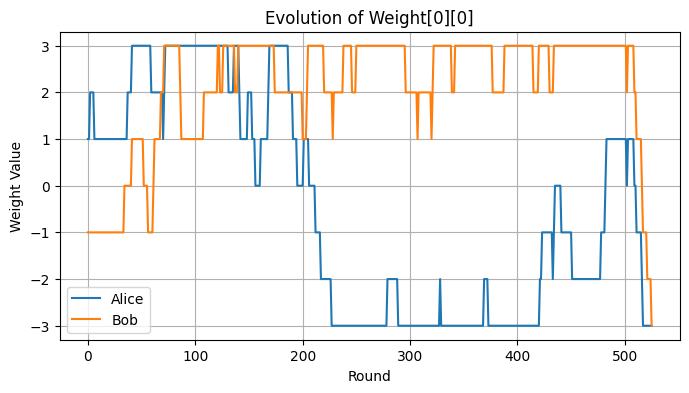

In [ ]:
plt.figure(figsize=(8, 4))
idx = (0, 0)
plt.plot([w[idx] for w in history_Alice], label="Alice")
plt.plot([w[idx] for w in history_Bob], label="Bob")
plt.title("Evolution of Weight[0][0]")
plt.xlabel("Round")
plt.ylabel("Weight Value")
plt.legend()
plt.grid(True)
plt.show()

### **7- Final Heatmaps**

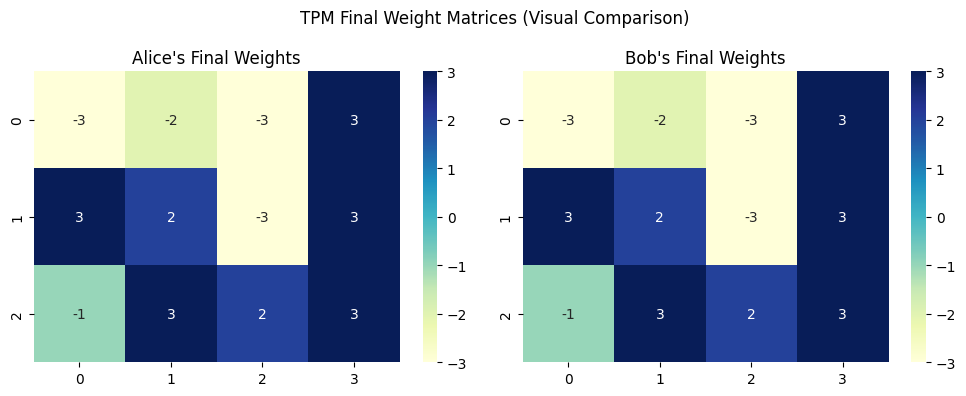

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.heatmap(W_Alice, annot=True, cmap="YlGnBu", ax=axs[0])
axs[0].set_title("Alice's Final Weights")

sns.heatmap(W_Bob, annot=True, cmap="YlGnBu", ax=axs[1])
axs[1].set_title("Bob's Final Weights")

plt.suptitle("TPM Final Weight Matrices (Visual Comparison)")
plt.tight_layout()
plt.show()

##**Section 2:** TPM Attack Simulation (Eve's Perspective)

In this section, we simulate a passive adversary, **Eve**, who also deploys a Tree Parity Machine and attempts to synchronize with Alice and Bob by observing the same public exchanges.

The model assumes Eve has full visibility of:

* The shared random inputs,
* The exchanged outputs (τ),
* The update rules used.

While the synchronization mechanism was introduced in the previous section, we briefly revisit it here from the adversary’s perspective to make Eve’s challenges and limitations explicit.


Despite having this information, Eve cannot control the interaction she must **guess when to update**, using the same τ comparison logic. As the simulation shows, **Eve’s TPM consistently lags behind** Alice and Bob's synchronization. More interestingly, we capture and visualize this phenomenon by plotting:

* The **distance between Eve and Alice/Bob** over time,
* Comparative synchronization trajectories,
* Points of divergence, demonstrating the inherent asymmetry faced by an eavesdropper.

This reinforces a key idea in neural cryptography: even if the communication is observable, synchronization is not guaranteed unless the party can participate fully in the exchange.

This insight adds weight to the claim that **TPM-based key exchange offers a naturally resilient structure** against passive attacks, particularly when properly parameterized.

### **1- Running the Synchronization with Eve**

To simulate Eve’s capabilities more concretely, we re-run the synchronization process with all three parties Alice, Bob, and Eve observing the same inputs. The core logic follows these rules:

* **All three parties (Alice, Bob, Eve) receive the same random input vectors at each step**.
* **Alice and Bob update their weights only when their outputs match**.
* **Eve, however, updates her weights only when her output matches Alice’s output, as observed from intercepted communication**.

In this setup:

* **Alice and Bob are engaged in an interactive mutual learning process**.
* **Eve, as a passive observer, attempts to synchronize without any ability to influence the data flow**.

This simulation allows us to study whether, over time, Eve can eventually synchronize her weights with Alice and Bob and under what conditions such an attack might be viable.

In [ ]:
# Eve's Attempt to Synchronize with Alice & Bob
# This simulates a passive attack where Eve listens but isn't involved in communication

# Reinitialize weights so this simulation is fresh
W_Alice = initialize_weights()
W_Bob = initialize_weights()
W_Eve = initialize_weights()

# Keep track of differences between Eve vs Alice, and Bob vs Alice
diffs_Eve = []
diffs_Bob = []

# Track Eve’s weight matrix over time for analysis
history_Eve = [W_Eve.copy()]
history_A = [W_Alice.copy()]
history_B = [W_Bob.copy()]

for step in range(max_rounds):
    X = generate_input()

    out_A = neuron_output(W_Alice, X)
    out_B = neuron_output(W_Bob, X)
    out_E = neuron_output(W_Eve, X)

    tau_A = tpm_output(out_A)
    tau_B = tpm_output(out_B)
    tau_E = tpm_output(out_E)

    # Alice and Bob update only if their outputs match
    if tau_A == tau_B:
        W_Alice = update_weights(W_Alice, X, out_A, tau_A)
        W_Bob = update_weights(W_Bob, X, out_B, tau_B)

        # Eve updates ONLY if her output matches Alice’s
        if tau_E == tau_A:
            W_Eve = update_weights(W_Eve, X, out_E, tau_E)

    # Track differences
    diffs_Eve.append(np.sum(np.abs(W_Alice - W_Eve)))
    diffs_Bob.append(np.sum(np.abs(W_Alice - W_Bob)))

    # Save Eve’s weight matrix for visualization
    history_Eve.append(W_Eve.copy())
    history_A.append(W_Alice.copy())
    history_B.append(W_Bob.copy())

    # Check for Alice & Bob sync
    if diffs_Bob[-1] == 0:
        print(f" Alice & Bob synchronized in {step + 1} rounds.")
        break
else:
    print(" Alice & Bob failed to synchronize within the limit.")

✅ Alice & Bob synchronized in 120 rounds.


### **2- Comparing Final TPM States (Heatmap View)**

Finally, we provide a side-by-side visualization of the internal weights of each participant after the synchronization process ends:

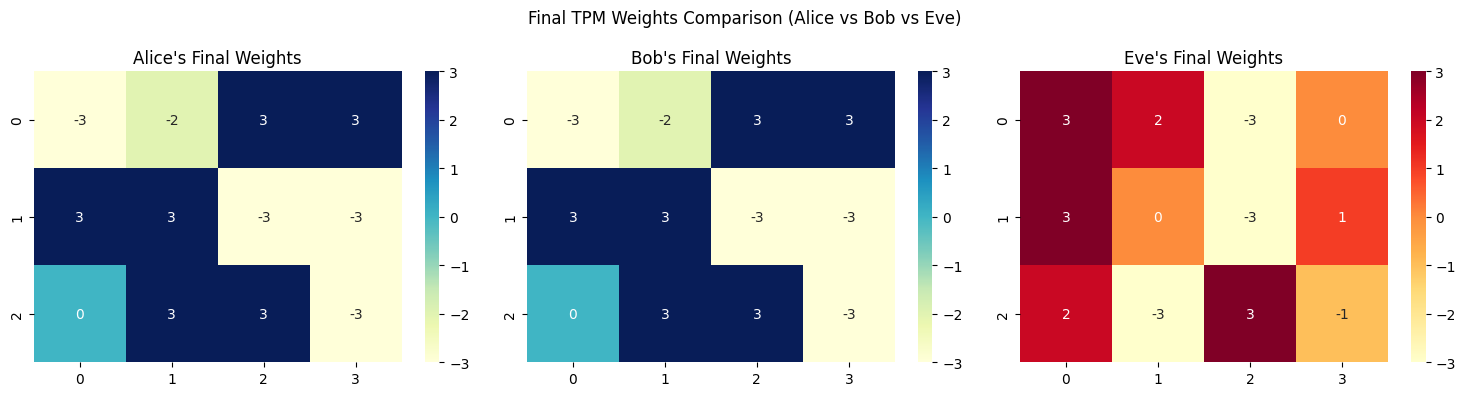

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
sns.heatmap(W_Alice, annot=True, cmap="YlGnBu", ax=axs[0])
axs[0].set_title("Alice's Final Weights")

sns.heatmap(W_Bob, annot=True, cmap="YlGnBu", ax=axs[1])
axs[1].set_title("Bob's Final Weights")

sns.heatmap(W_Eve, annot=True, cmap="YlOrRd", ax=axs[2])
axs[2].set_title("Eve's Final Weights")

plt.suptitle("Final TPM Weights Comparison (Alice vs Bob vs Eve)")
plt.tight_layout()
plt.show()

### **3- Visualizing Eve’s Disadvantage in Synchronization**

To further emphasize the divergence between Eve and the legitimate parties, we now plot the evolution of weight distances between Alice-Bob and Alice-Eve across synchronization rounds. While the heatmaps previously gave us a static snapshot of final weight similarity, this line plot reveals the dynamics of the synchronization process. As shown below, Bob’s weights rapidly converge to Alice’s, while Eve consistently trails behind visually confirming the passive attack’s structural disadvantage.

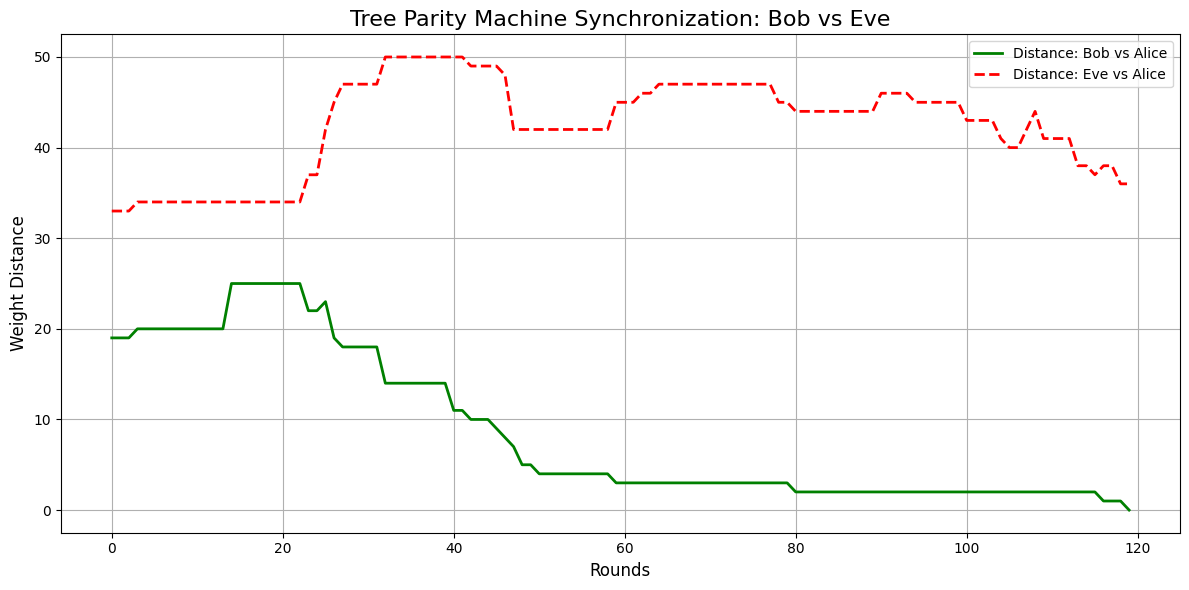

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(diffs_Bob, label="Distance: Bob vs Alice", color="green", linewidth=2)
plt.plot(diffs_Eve, label="Distance: Eve vs Alice", color="red", linestyle="--", linewidth=2)

plt.title("Tree Parity Machine Synchronization: Bob vs Eve", fontsize=16)
plt.xlabel("Rounds", fontsize=12)
plt.ylabel("Weight Distance", fontsize=12)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## **Conclusion**

This study explored the **Tree Parity Machine (TPM)** as a foundation for neural cryptography, highlighting its potential as a key exchange mechanism resistant to passive eavesdropping. Through simulations, we demonstrated the following key insights:

* **Mutual learning between Alice and Bob** enables rapid synchronization under shared inputs and update rules.

* **A passive adversary (Eve)**, despite observing the same inputs and outputs, faces a fundamental disadvantage: she cannot influence the exchange and must guess when to update. This leads to persistent desynchronization.

* **Visualization tools**, including heatmaps and synchronization distance plots, clearly illustrate the dynamics and resilience of the TPM protocol under attack.

These results reinforce the promise of TPM-based cryptography as a lightweight and computation-efficient alternative for secure key exchange particularly in environments where traditional public-key cryptography may be unsuitable (e.g., IoT or constrained devices).

From a practical standpoint, **TPM-based synchronization** is especially appealing for resource-constrained systems such as:

* **IoT devices** in smart homes and industrial control systems (ICS),

* **Wearable devices** where low power and fast key establishment are critical,

* **Ad hoc wireless sensor networks** or embedded systems requiring lightweight mutual authentication,

* **Post-quantum embedded systems**, where TPMs offer a low-complexity fallback resistant to quantum key recovery via Shor’s algorithm.

However, while the passive attack scenario affirms the strength of TPM synchronization, future work should explore **active adversaries**, **parameter tuning**, and **hybrid cryptosystems** to further assess and enhance security guarantees.

In conclusion, neural cryptography once considered a curiosity stands as a viable and theoretically sound direction for advancing modern cryptographic schemes.